# Проект: классификация

In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import plotly
import plotly.express as px

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [308]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [309]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
null_values = list(df.isnull().sum().sort_values(ascending=False).items())
print(f"""Пропущенные есть в колонках: {null_values[0][0]} ;
Число пропусков:  {null_values[0][1]}.""")

Пропущенные есть в колонках: balance ;
Число пропусков:  25.


### Задание 2

In [310]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
print(df['job'].value_counts())
print()
print('Пропущенные значения в колонке job обозначены словом "unknown"')

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

Пропущенные значения в колонке job обозначены словом "unknown"


### Задание 3

In [311]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def format_balance(x,**kwargs):
    if x is np.nan:
        return np.nan
        print('nan')
    return float(x.replace('$','').replace(' ','').split(',')[0])
    
df['balance'] = df['balance'].apply(format_balance) 
df['balance'].mean()

1529.1290293615875

### Задание 4

In [312]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
balance_median = df['balance'].median()
df['balance'].fillna(balance_median,inplace=True)
df['balance'].mean()

1526.9360329690019

### Задание 5

In [313]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
columns = ['job','education']
for item in columns:
    mode = df[item].mode().item()
    df[item] = df[item].apply(lambda x: mode if x == 'unknown' else x)

mode_job = df['job'].mode().item()
mode_edu = df['education'].mode().item()
df.query('job==@mode_job & education==@mode_edu')['balance'].mean()

1598.8829787234042

### Задание 6

In [314]:
# удалите все выбросы для признака balance
quantiles = df['balance'].quantile([0.25,0.75])
q1 = quantiles.loc[0.25]
q3 = quantiles.loc[0.75]
iqr = q3 - q1
print(q1 - 1.5*iqr)
print(q3+1.5*iqr)
df.drop(df.query('balance < @q1-1.5*@iqr | balance > @q3+1.5*@iqr').index,inplace=True)

print(f'Число строк после удаления выбросов: {df.shape[0]}')

-2241.0
4063.0
Число строк после удаления выбросов: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

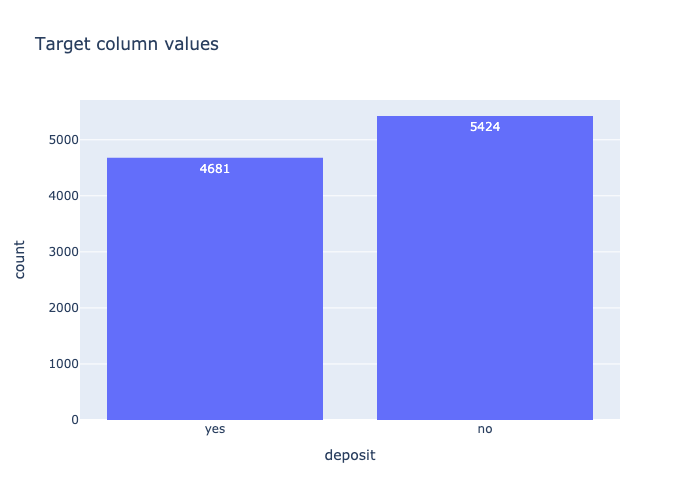

In [315]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
fig = px.histogram(df,x='deposit',title='Target column values',text_auto=True) 
fig.show('png')

Классы сбалансированы

### Задания 2 и 3

In [316]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [317]:
# заменем целевой признак deposit на булевые: 1 - 'yes', 0 - 'no'
df['deposit'] = df['deposit'].apply(lambda x:int(1) if x == 'yes' else int(0))

Построим графики зависимости относительно целевого признака для каждой количественной переменной 

1. **Age**

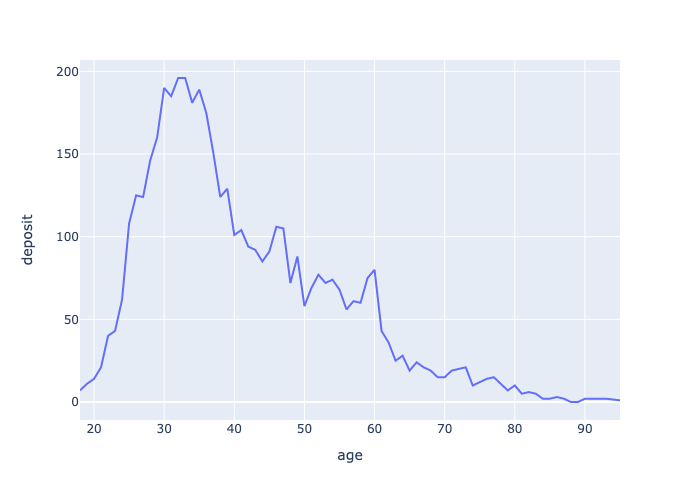

In [318]:
age = df.groupby('age')['deposit'].sum().reset_index()
fig = px.line(age,x='age',y='deposit')
fig.show('png')

Видно, что больше всего депозитов открывают люди в возрасте 30-36 лет.

2. **Balance**

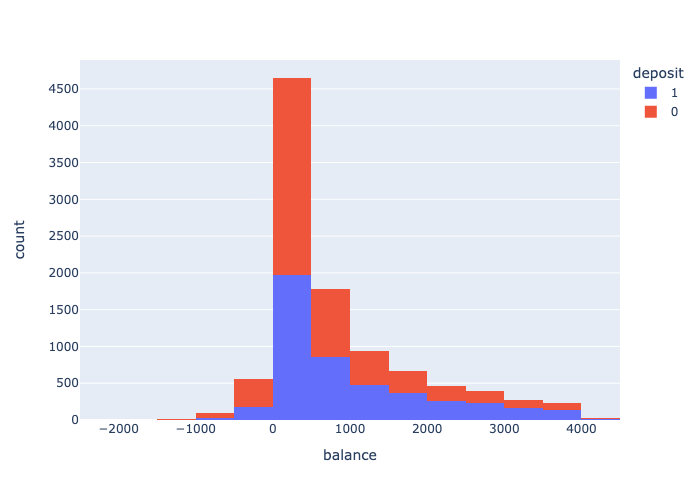

In [319]:
fig = px.histogram(df, x="balance", nbins=20,color='deposit')
fig.show('png')

Можно заметить, что примерно половина клиентов из каждой корзины баланса делает депозит, при этом при увеличении баланса доля клиентов, сделавших депозит, растет.

3. **Day** - день, когда был последний контакт.

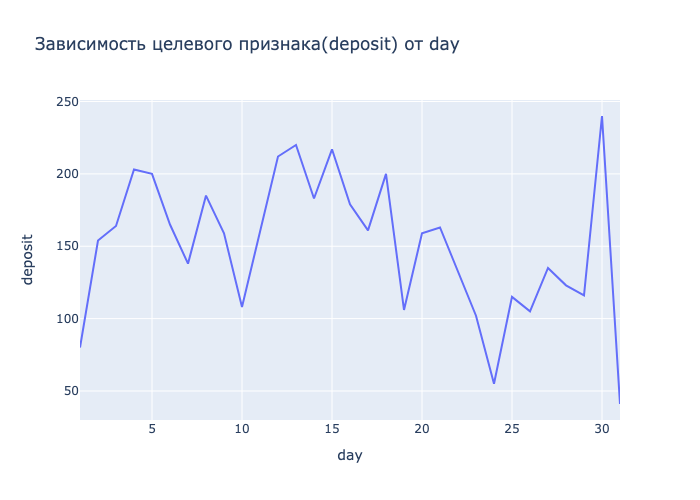

In [320]:
fig = px.line(pd.DataFrame(df.groupby('day')['deposit'].sum()).reset_index(), x='day', y='deposit', title='Зависимость целевого признака(deposit) от day')
fig.show('png')


На графике виден максимум 30 числа месяца , который связан вероятно с получением клиентами  
заработной платы в этот день.

4. **Duration** - продолжительность контакта в секундах.

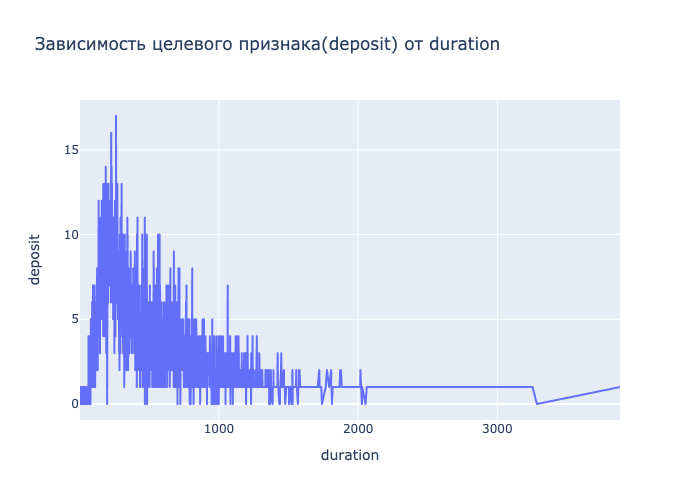

In [321]:
fig = px.line(pd.DataFrame(df.groupby('duration')['deposit'].sum()).reset_index(), x='duration', y='deposit', title='Зависимость целевого признака(deposit) от duration')
fig.show('png')


График показывает, что максимальное число открытых депозитов было примерно при 300 секундах  
продолжительности звонка и до 300 секунд число открытых депозитов растет, а затем падает.

5. **Campaign** - количество контактов с этим клиентом в течение текущей кампании

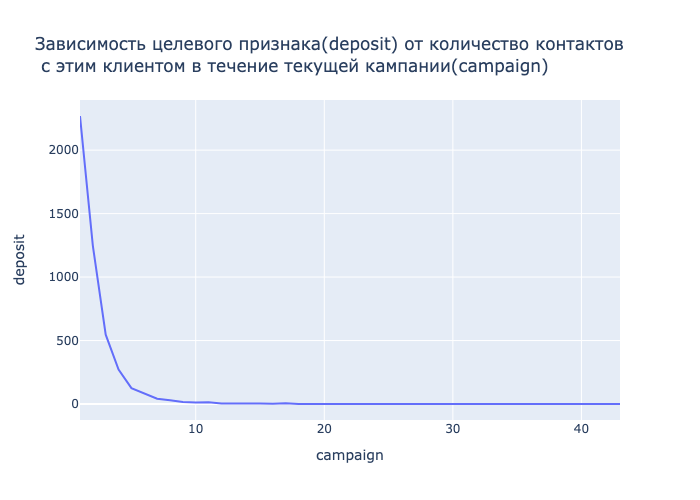

In [322]:
fig = px.line(pd.DataFrame(df.groupby('campaign')['deposit'].sum()).reset_index(), x='campaign', y='deposit', title='Зависимость целевого признака(deposit) от количество контактов  <br> с этим клиентом в течение текущей кампании(campaign)')
fig.show('png')

График зависимости показывает, что вероятно стоит ограничиться числом контактов с клиентом  
до 5 штук.

6. **Previous** - количество контактов до текущей кампании

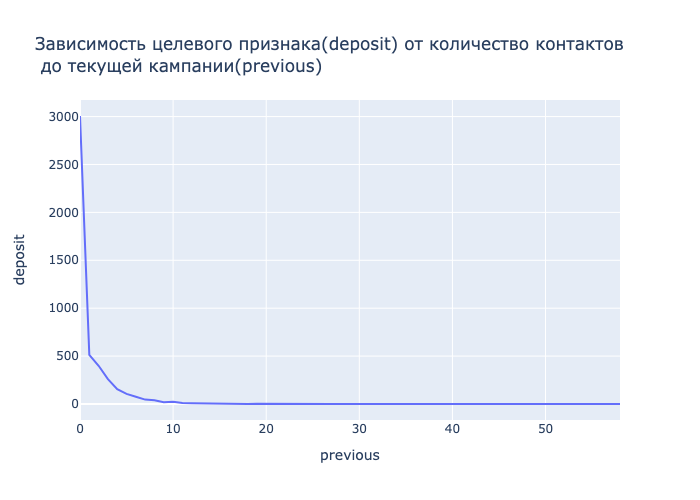

In [323]:
fig = px.line(pd.DataFrame(df.groupby('previous')['deposit'].sum()).reset_index(), x='previous', y='deposit', title='Зависимость целевого признака(deposit) от количество контактов <br> до текущей кампании(previous)')
fig.show('png')

Чем меньше контактов было с клиентом до текущей кампании, тем выше шанс открытия депозита клиентом.  
При контактак более 5 шансы открытия депозита становятся нулевыми.

### Задания 4 и 5

In [324]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include='object')
#постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome
count,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570


**1. Job**

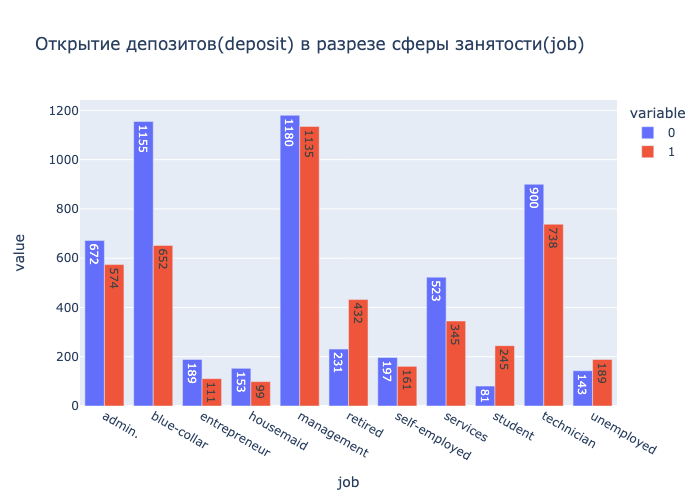

In [325]:
fig = px.bar(df.pivot_table(
    values='day',
    index='job',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index(), x='job', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе сферы занятости(job)')
fig.show('png')



Имеется тенденция к согласию открыть депозит у клиентов, находящихся на пенсии(retired), среди  студентов(student), безработных(unemployed). Больше всего отказываются: клиенты, в рабочих  специальностях(blue-collar), предприниматели(entrepreneur), работники сферы услуг(services)

**2. MARITAL(семейное положение)**

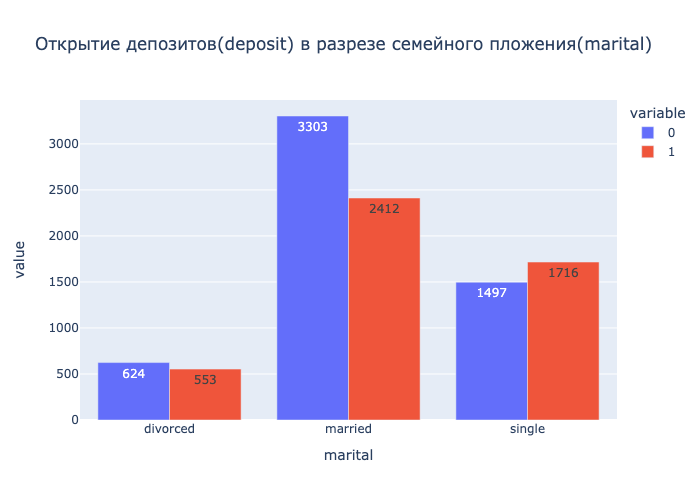

In [326]:
fig = px.bar(df.pivot_table(
    values='day',
    index='marital',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index(), x='marital', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе семейного пложения(marital)')
fig.show('png')


Видно, что холостные(single) более склонны открывать депозиты.

**3. EDUCATION(уровень образования)**

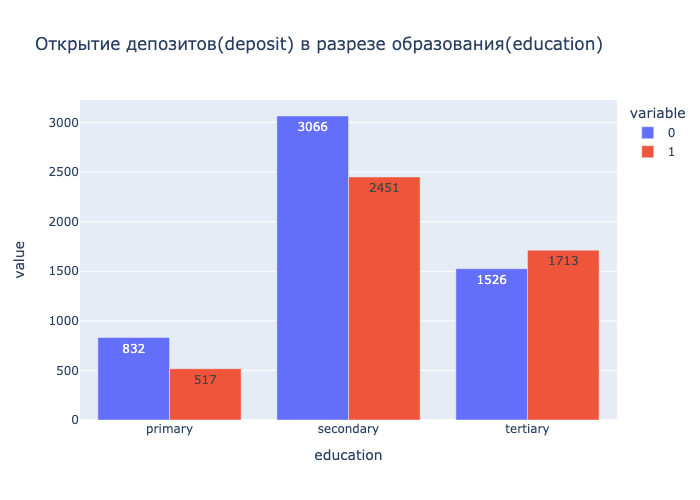

In [327]:
fig = px.bar(df.pivot_table(
    values='day',
    index='education',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index(), x='education', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе образования(education)')
fig.show('png')

Видно, что люди с образованием tertiary более склонны открывать депозиты.

**4. Housing(есть ли кредит на жилье)**

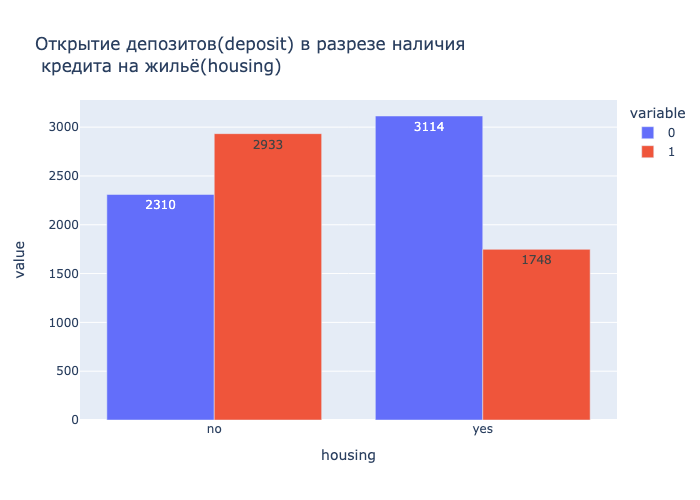

In [328]:
fig = px.bar(df.pivot_table(
    values='day',
    index='housing',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index(), x='housing', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе наличия <br> кредита на жильё(housing)')
fig.show('png')

Видно, что клиенты без кредита на жилье в своем большинстве открывают депозит,  
тогда как люди с кредитом на жилье чаще отказываются от открытия депозита.

**5. Month(месяц, в котором был последний контакт)**

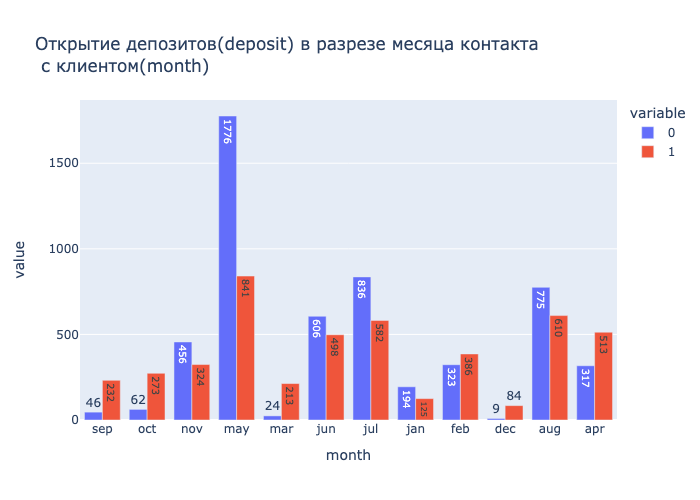

In [329]:
fig = px.bar(df.pivot_table(
    values='day',
    index='month',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index(), x='month', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе месяца контакта <br> с клиентом(month)')
fig.show('png')

Больше всего люди склонны открывать депозит в сентябре, октябре, марте, декабре и апреле.

**6. Poutcome(результат прошлой маркетинговой кампании)**

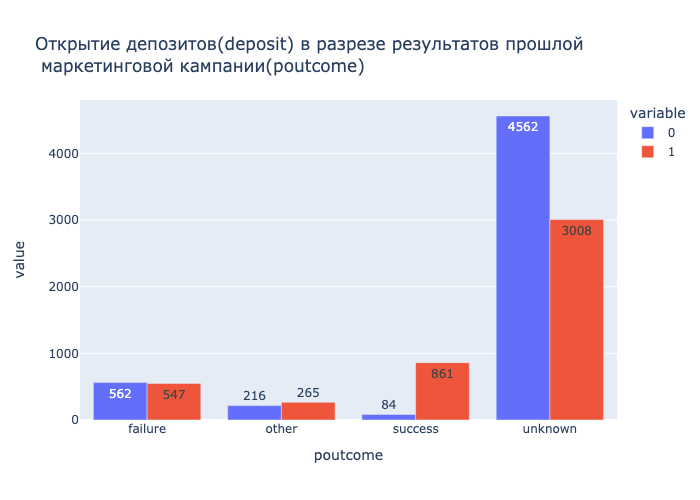

In [330]:
fig = px.bar(df.pivot_table(
    values='day',
    index='poutcome',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index(), x='poutcome', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе результатов прошлой <br> маркетинговой кампании(poutcome)')
fig.show('png')



Клиенты, открывшие депозит в прошлую кампанию, в большинстве своем открывают депозит и в текущую кампанию.

### Задание 6

In [331]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

Воспользуемся прошлым графиком и заметим, что для статуса success предыдущей маркетинговой кампании  
 успех в текущей превалирует над количеством неудач

### Задание 7

In [332]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
percent_failure = round((df.groupby('month')['deposit'].count() - 
                         df.groupby('month')['deposit'].sum()) / 
                         df.groupby('month')['deposit'].count() * 100).sort_values(ascending=False)
print(f'В {percent_failure.index[0]} месяце больше всего отказывались от открытия депозита.')

В may месяце больше всего отказывались от открытия депозита.


### Задание 8

In [333]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def create_age_group(age):
    """ Разбивает клиентов на возрастные группы

    Args:
        age (int): возраст

    Returns:
        age_group(object): возрастная группа
    """
    if age < 30:
        age_group = '<30'
    elif 30 <= age < 40:
        age_group = '30-40'
    elif 40 <= age < 50:
        age_group = '40-50'
    elif 50 <= age < 60:
        age_group = '50-60'
    else:
        age_group = '60+'
    return age_group

df['age_group'] = df['age'].apply(create_age_group)


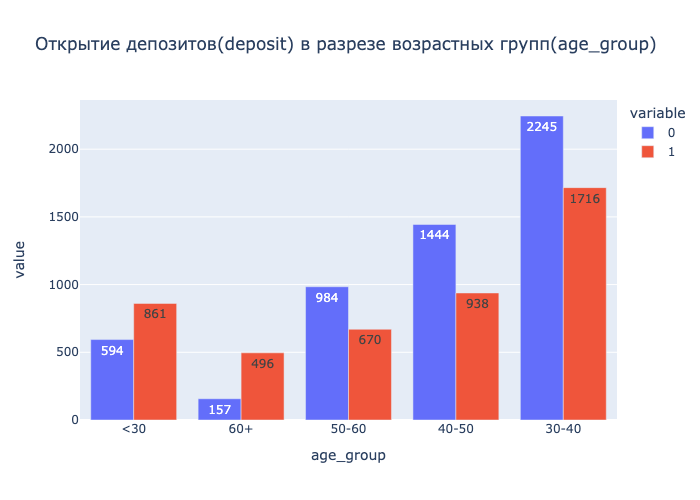

In [334]:
fig = px.bar(df.pivot_table(
    values='day',
    index='age_group',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index(), x='age_group', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Открытие депозитов(deposit) в разрезе возрастных групп(age_group)')
fig.show('png')

Более всего к открытию депозита склонны возрастные группы <30 и 60+, этот результат согласуется с тем ,  
что люди на пенсии и студенты тоже склонны чаще открывать депозит.

### Задания 9 и 10

In [335]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

см пункт **2. MARITAL(семейное положение)**

In [336]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

см пункт **3. EDUCATION(уровень образования)**

In [337]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

см пункт **1. Job**

### Задание 11

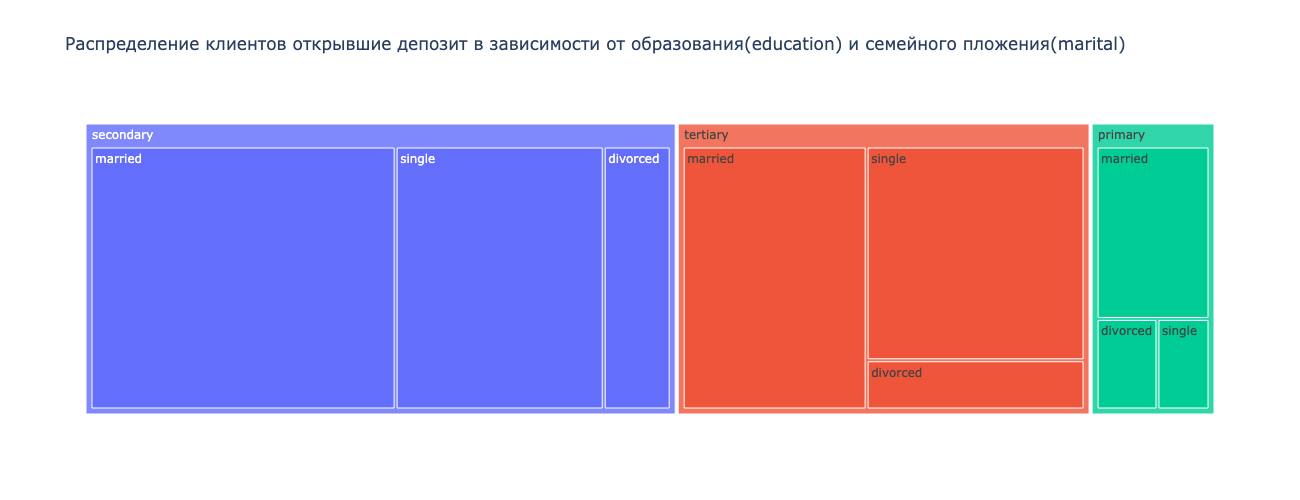

In [338]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
p1 = df[df['deposit']==1]
p1 = pd.DataFrame(p1.pivot_table(
    values='age',
    index=['education', 'marital'],    
    columns='deposit',
    aggfunc='count',
    fill_value=0))

fig = px.treemap(
    data_frame=p1, #DataFrame
    path=[p1.index.get_level_values(0), p1.index.get_level_values(1)], #категориальный признак, для которого строится график
    values=1, #параметр, который сравнивается
    height=500, #высота
    width=1300, #ширина
    title='Распределение клиентов открывшие депозит в зависимости от образования(education) и семейного пложения(marital)' #заголовок
)
#отображаем график
fig.show('png')

Наибольшая группа - люди с статусом married и образованием secondary.

## Часть 3: преобразование данных

### Задание 1

In [339]:
# преобразуйте уровни образования
label_encoder = LabelEncoder() # кодируем порядковым кодировщиком
data_educ = label_encoder.fit_transform(df['education'])
df['education'] = data_educ

# преобразуйте возрастные группы
data_age = label_encoder.fit_transform(df['age_group'])
df['age_group'] = data_age

### Задания 2 и 3

In [340]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['housing'] = df['housing'].apply(lambda x: int(1) if x == 'yes' else int(0))
df['default'] = df['default'].apply(lambda x: int(1) if x == 'yes' else int(0))
df['loan'] = df['loan'].apply(lambda x: int(1) if x == 'yes' else int(0))

### Задание 4

In [341]:
# создайте дамми-переменные
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'], 
                    prefix=['job', 'marital', 'contact', 'month', 'poutcome'])
df = df.drop(columns=['age', 'education', 'default', 'loan', 'housing'])

### Задания 5 и 6

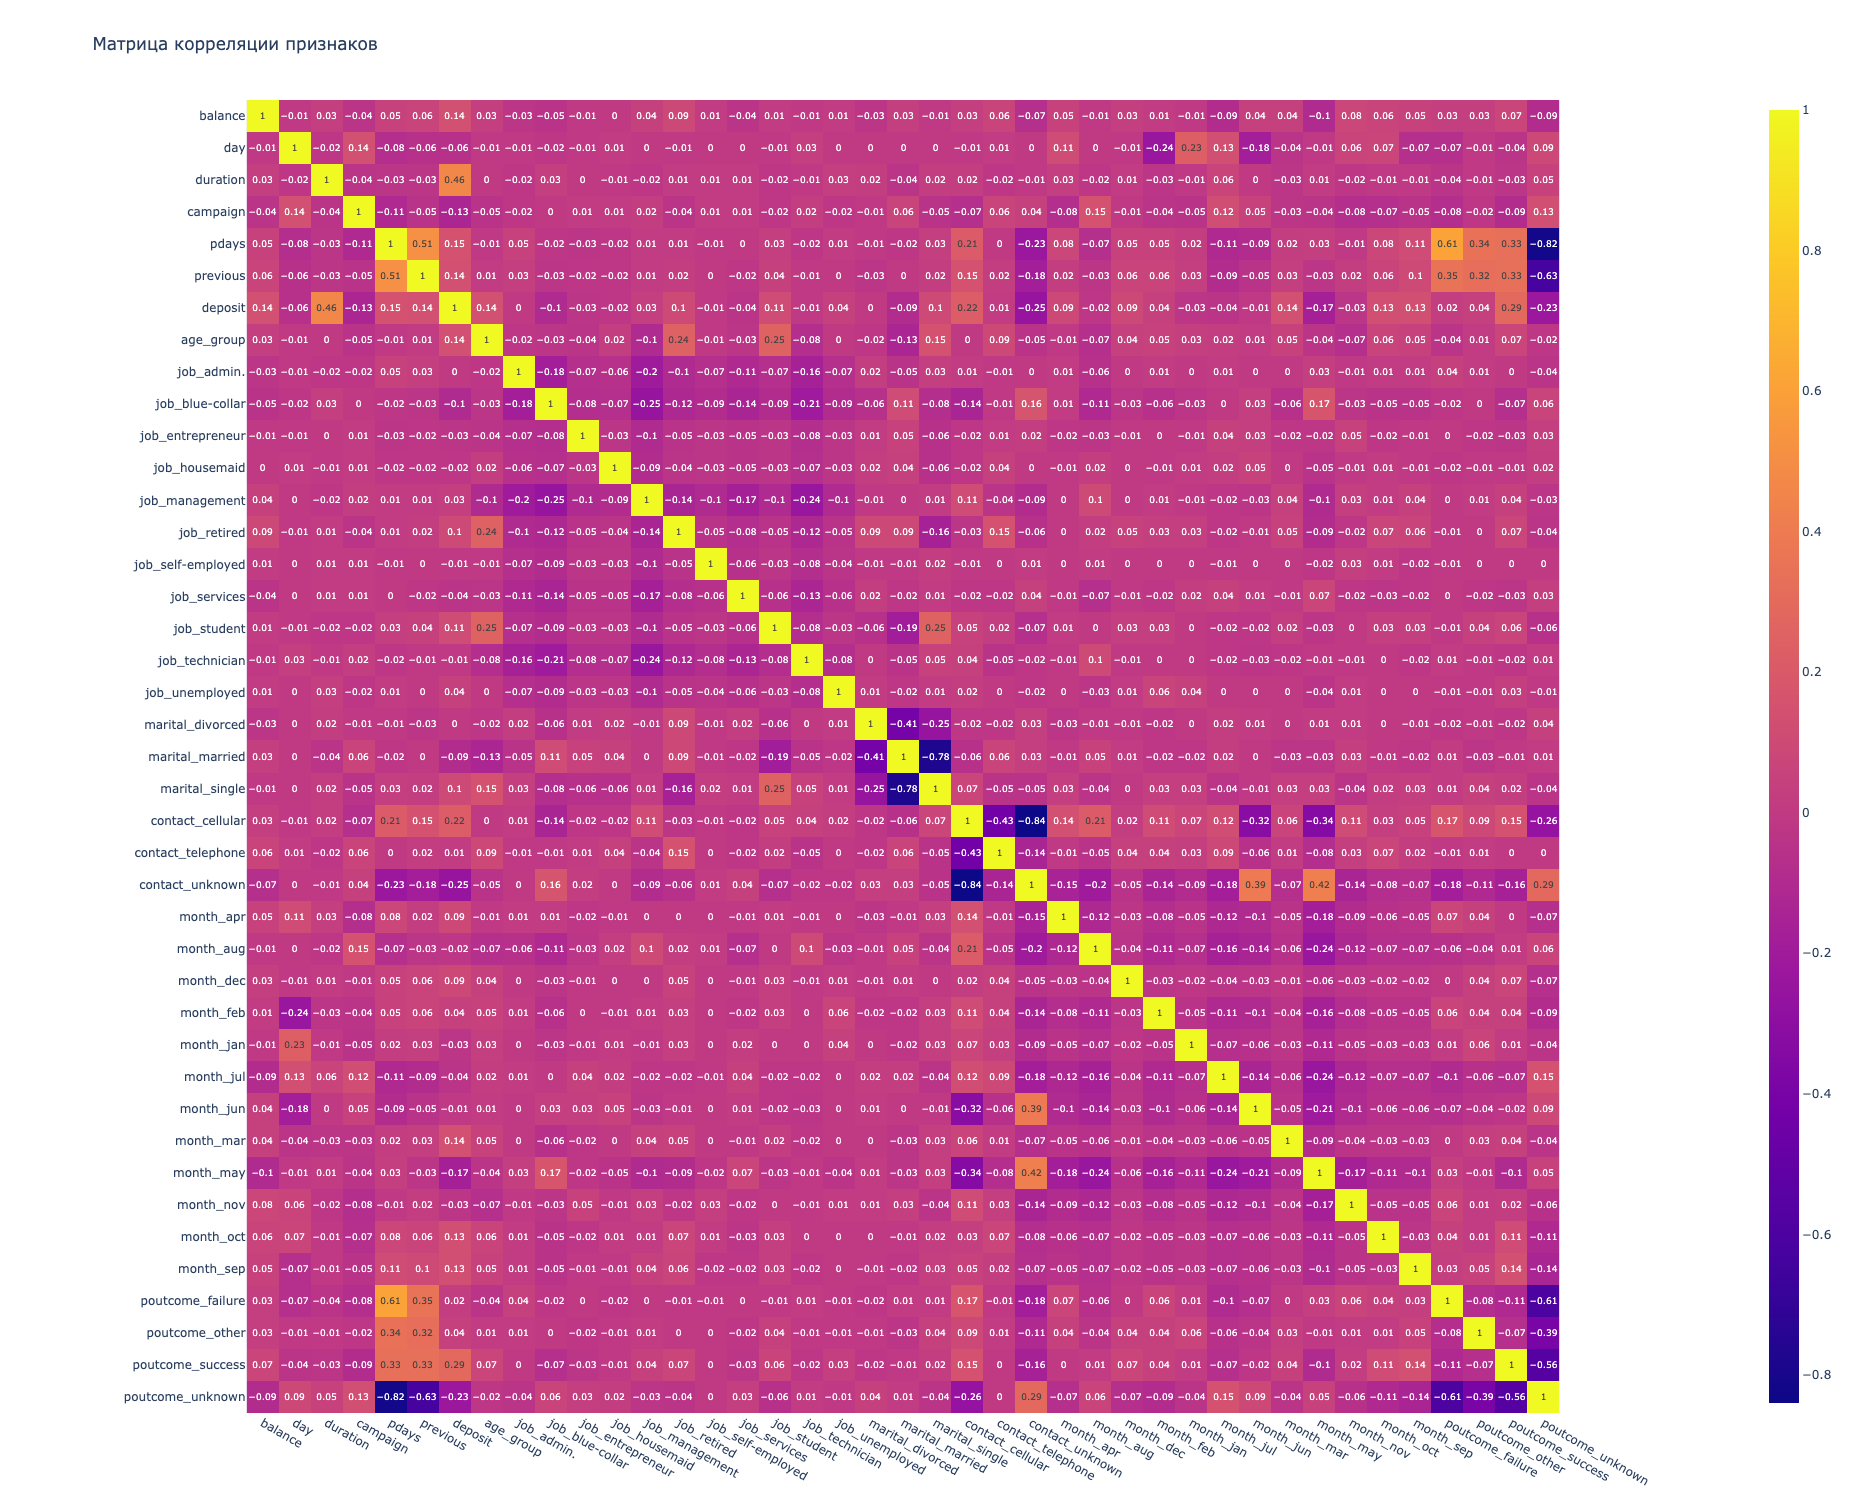

In [342]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corrs = round(df.corr(), 2)
fig = px.imshow(
    img=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    text_auto=True,    
    title='Матрица корреляции признаков',
    width=1850,
    height=1500
    )
fig.show('png')


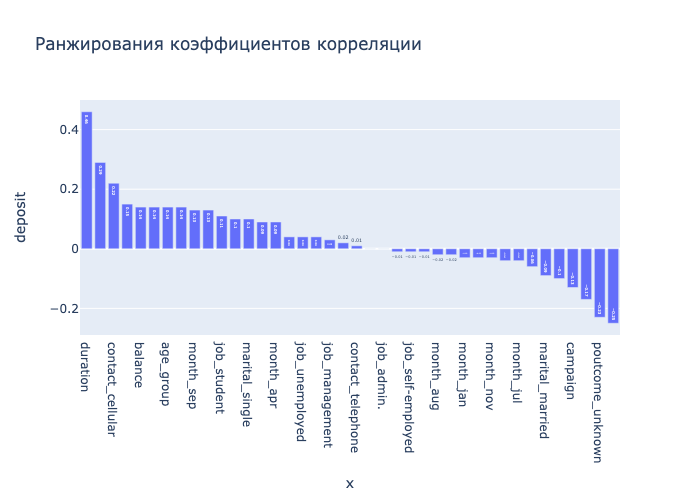

duration            0.46
poutcome_success    0.29
contact_cellular    0.22
Name: deposit, dtype: float64

In [343]:
corrs = round(df.corr(), 2).drop('deposit', axis=0)
fig = px.bar(corrs['deposit'].sort_values(ascending=False),
             x=list(corrs['deposit'].sort_values(ascending=False).index),
             y='deposit',
             text_auto=True,
             title='Ранжирования коэффициентов корреляции'
             )
fig.show('png')
corrs['deposit'].sort_values(ascending=False)[:3]



Мультиколлинеарность признаков отсутсвует.

Признаки наиболее коррелирующие с целевой переменной:

   - продолжительность контакта в секундах(duration)
   - успех результата прошлой маркетинговой кампании(poutcome_success)
   - контакт с клиентом по сотовому(contact_cellular)



### Задания 7 и 8

In [344]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print(f'Размер обучающей выборки X_train={X_train.shape}, y_train={y_train.shape[0]}')
print(f'Размер тестовой выборки X_test={X_test.shape}, y_test={y_test.shape[0]}')

Размер обучающей выборки X_train=(6770, 40), y_train=6770
Размер тестовой выборки X_test=(3335, 40), y_test=3335


In [345]:
# рассчитайте необходимые показатели
y_test.mean()

0.46326836581709147

### Задание 9

In [346]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

kbest = SelectKBest(score_func = f_classif, k=25)
kbest.fit(X_train, y_train)
kbest.get_feature_names_out()
kbest_col = list(kbest.get_feature_names_out())
X_train_kbest = X_train[kbest_col]
X_test_kbest = X_test[kbest_col]
kbest_col

['balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'job_blue-collar',
 'job_retired',
 'job_services',
 'job_student',
 'marital_married',
 'marital_single',
 'contact_cellular',
 'contact_unknown',
 'month_apr',
 'month_dec',
 'month_jul',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_other',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [347]:
# нормализуйте данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
X_train_scal = mm_scaler.fit_transform(X_train_kbest)
X_train_scal = pd.DataFrame(X_train_scal, columns=X_train_kbest.columns)
X_test_scal = mm_scaler.transform(X_test_kbest)
X_test_scal = pd.DataFrame(X_test_scal, columns=X_test_kbest.columns)
X_test_scal['balance'].mean()

0.46823674223097866

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [348]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_reg.fit(X_train_scal,y_train)
y_train_pred = log_reg.predict(X_train_scal)
y_test_pred = log_reg.predict(X_test_scal)

print(f'Метрики на обучающих данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Метрики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')



Метрики на обучающих данных
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

Метрики на тестовых даннных
               precision    recall  f1-score   support

           0       0.80      0.86      0.83      1790
           1       0.82      0.75      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

In [349]:
# обучите решающие деревья, настройте максимальную глубину
tree_model = tree.DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=6)
tree_model.fit(X_train_scal, y_train)
y_test_pred = tree_model.predict(X_test_scal)
y_train_pred = tree_model.predict(X_train_scal)
print(f'Метрики на обучающих данных данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Метрики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')


Метрики на обучающих данных данных
               precision    recall  f1-score   support

           0       0.80      0.87      0.84      3634
           1       0.83      0.76      0.79      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.81      0.81      6770
weighted avg       0.82      0.82      0.82      6770

Метрики на тестовых даннных
               precision    recall  f1-score   support

           0       0.79      0.84      0.81      1790
           1       0.80      0.75      0.77      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.79      0.79      3335
weighted avg       0.80      0.80      0.79      3335



### Задание 5

In [350]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
# задаём сетку параметров
param_grid = [
              {'min_samples_split': [2, 5, 7, 10] , # Минимальное количество выборок, необходимое для разделения внутреннего узла
               'max_depth':[3,5,7] # Максимальная глубина дерева
              }              
]

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy',
        
        random_state=42, #генератор случайных чисел
        ), 
    param_grid=param_grid, 
    n_jobs = -1,
    scoring='f1'
)  

grid_search.fit(X_train_scal, y_train) 
print(f'Best Hyperparameter Values: {grid_search.best_params_}')
print(f'Best Models:{grid_search.best_estimator_}')
print(f'Best score Cross validation: {grid_search.best_score_:.3f}')
y_test_pred = grid_search.predict(X_test_scal)
y_train_pred = grid_search.predict(X_train_scal)
print(f'Метрики на обучающих данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Метрики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')

Best Hyperparameter Values: {'max_depth': 7, 'min_samples_split': 10}
Best Models:DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=10,
                       random_state=42)
Best score Cross validation: 0.788
Метрики на обучающих данных
               precision    recall  f1-score   support

           0       0.85      0.84      0.84      3634
           1       0.81      0.82      0.82      3136

    accuracy                           0.83      6770
   macro avg       0.83      0.83      0.83      6770
weighted avg       0.83      0.83      0.83      6770

Метрики на тестовых даннных
               precision    recall  f1-score   support

           0       0.82      0.80      0.81      1790
           1       0.78      0.80      0.79      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [351]:
# обучите на ваших данных случайный лес
forest = ensemble.RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_leaf=5,
    criterion='gini'
)
forest.fit(X_train_scal, y_train)
y_train_pred = forest.predict(X_train_scal)
y_test_pred = forest.predict(X_test_scal)
print(f'Метрики на обучающих данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Метрики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')


Метрики на обучающих данных
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      3634
           1       0.84      0.88      0.86      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.87      0.86      6770
weighted avg       0.87      0.86      0.86      6770

Метрики на тестовых даннных
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      1790
           1       0.80      0.85      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [352]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=300,
    random_state=42,
    min_samples_leaf=5,
    learning_rate=0.05,
    max_depth=5         
)

gb.fit(X_train_scal, y_train)
y_train_pred = gb.predict(X_train_scal)
y_test_pred = gb.predict(X_test_scal)
print(f'Метрики на обучающих данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Метрики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')


Метрики на обучающих данных
               precision    recall  f1-score   support

           0       0.92      0.89      0.91      3634
           1       0.88      0.91      0.89      3136

    accuracy                           0.90      6770
   macro avg       0.90      0.90      0.90      6770
weighted avg       0.90      0.90      0.90      6770

Метрики на тестовых даннных
               precision    recall  f1-score   support

           0       0.86      0.83      0.85      1790
           1       0.81      0.85      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335



### Задание 4

In [353]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', log_reg),
    ('dt',  tree_model),
    ('fm', forest)      
]

#Создаем объект класса стекинг
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=gb)
    

stack_model.fit(X_train_scal, y_train)
y_train_pred = stack_model.predict(X_train_scal)
y_test_pred = stack_model.predict(X_test_scal)
print(f'Метрики на обучающих данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Метрики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')


Метрики на обучающих данных
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      3634
           1       0.84      0.87      0.86      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Метрики на тестовых даннных
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      1790
           1       0.79      0.84      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.83      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задание 5

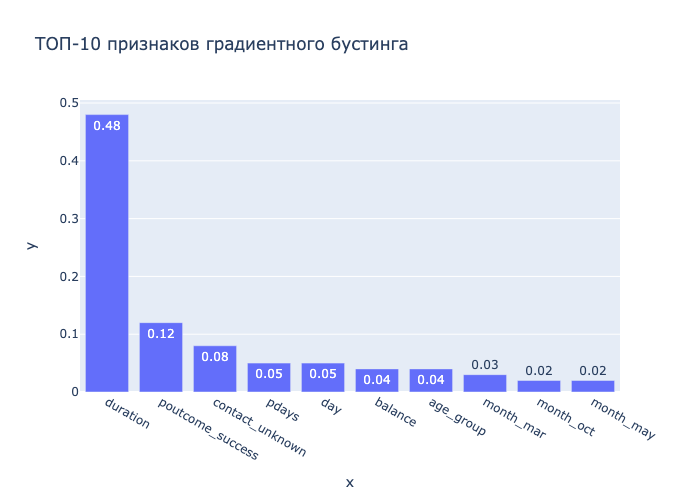

In [354]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
features = pd.DataFrame([gb.feature_importances_], columns=gb.feature_names_in_)
fig = px.bar(x = list(features.loc[0].sort_values(ascending=False)[0:10].index),
    y=round(features.loc[0].sort_values(ascending=False)[0:10], 2),
    text_auto=True,
    title='ТОП-10 признаков градиентного бустинга'    
)
fig.show('png')

### Задания 6,7,8

In [355]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scal, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scal))

  return score

In [356]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scal, y_train)
y_test_pred = model.predict(X_test_scal)

score = metrics.f1_score(y_test, y_test_pred)
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'F1 for test data={score:.2f}')
print(f'Accuracy for test data={metrics.accuracy_score(y_test, y_test_pred):.2f}')

[I 2024-04-07 21:53:10,997] A new study created in memory with name: RandomForestClassifier
[I 2024-04-07 21:53:11,567] Trial 0 finished with value: 0.9140722291407223 and parameters: {'n_estimators': 121, 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9140722291407223.
[I 2024-04-07 21:53:12,112] Trial 1 finished with value: 0.8617961842717543 and parameters: {'n_estimators': 140, 'max_depth': 18, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9140722291407223.
[I 2024-04-07 21:53:12,713] Trial 2 finished with value: 0.9099407915238393 and parameters: {'n_estimators': 133, 'max_depth': 21, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9140722291407223.
[I 2024-04-07 21:53:13,308] Trial 3 finished with value: 0.8652416356877324 and parameters: {'n_estimators': 156, 'max_depth': 25, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9140722291407223.
[I 2024-04-07 21:53:14,024] Trial 4 finished with value: 0.8641439205955335 and parameters: {'n

Наилучшие значения гиперпараметров {'n_estimators': 105, 'max_depth': 27, 'min_samples_leaf': 2}
F1 for test data=0.83
Accuracy for test data=0.84


**Вывод**  

В следующей таблице представлены метрики f1-score и Accuracy для различных моделей.
|Model|F1-score|Accuracy   |
|---|---|---|
|LogisticRegression|0.81|0.81|
|DecisionTreeClassifier|0.79|0.80|
|RandomForestClassifier|0.83|0.83|
|GradientBoostingClassifier|0.84|0.84|
|StackingClassifier|0.82|0.82|
|optuna|0.83|0.84|

Таким образом DecisionTreeClassifier показала наихудший результат и GradientBoostingClassifier - лучший.

Из графиков можно отметить следующие закономерности:
- клиенты, открывшие депозит в прошлую маркетиговую кампанию, склонны открыть депозит и в следующий раз, что говорит о лояльности;
- больше всего люди склонны открывать депозит в сентябре, октябре, марте, декабре и апреле;
- студенты и пенсионеры более склонны к открытию депозитов;
- стоит ограничиться числом контактов с клиентом (до 5 штук).

Как показал анализ, самыми важными признаками в данном исследовании являются:  
- **duration** - продолжительность контакта в секундах
- **poutcome_success** - результат прошлой маркетинговой кампании success(успех)
- **contact_unknown** - тип контакта с клиентом unknown(неизвестный)

